In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%env OMP_NUM_THREADS=32  # set number of threads
# %config InlineBackend.figure_format = 'retina'

env: OMP_NUM_THREADS=32  # set number of threads


In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

def eshow(m, **kwargs): 
    pl=enplot.plot(m,downgrade=4,ticks=5, **kwargs)
    enplot.show(pl)

# File Loading

We specify the filepaths here. In the first cell, we load in a map which has the WCS and shape information, with which we will crop all other maps to fit. When we take power spectra, we want all of the maps involved to have the same shape and WCS!

In [3]:
data_root = '/tigress/zequnl/cmb/data/from_choi/'
apopath = f'{data_root}/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
steve_apo = enmap.read_map(apopath)
shape, wcs = steve_apo.shape, steve_apo.wcs

Next, we load in the maps and masks. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask. 

In [4]:
# mapname_head = f"{data_root}/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
mapname_head = f"{data_root}/maps/filtered/ACTPol_148_deep56_pa1_f150_s14_4way_split"
mapname_tail = "filt_unpixwin.fits"

mask_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits"
mask_pol_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0.fits"
beam_filename = f"{data_root}/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"

# loop over splits and generate 
nsplits = 4
beam = nw.read_beam(beam_filename)

# we make the mask conform to the same WCS and shape
mask = enmap.read_map(mask_file)
mask = enmap.extract(mask, shape, wcs)

# read in the polarization mask
mask_pol = enmap.read_map(mask_pol_file)
mask_pol = enmap.extract(mask_pol, shape, wcs)

We correct for the pixel window function and apply the k-space filter using `preprocess_fourier`, with $|k_x| < 90$ and $|k_y| < 50$. The `preprocess_fourier` function will also call `enmap.extract` if you pass it `shape` and `wcs` information, in order to conform all the maps to the same geometry. If you load in a source map for example, you'll want to run `enmap.extract` on it like in the comments below, in order to get it to have the same shape and WCS as everything else.

### Legacy Support
There is an important flag here, `legacy_steve = True`. At the time of this writing, Steve's code applies a slightly incorrect k-space filter, and offsets the maps by `(-1,-1)` in `WCS.CRPIX`.

In [24]:
namap_list = []
for i in range(nsplits):
    
    # read map from disk and preprocess (i.e. k-space filter and pixwin)
    map_I = enmap.read_map(f"{mapname_head}{i}_srcadd_I_{mapname_tail}")  # get map
    map_Q = enmap.read_map(f"{mapname_head}{i}_Q_{mapname_tail}")
    map_U = enmap.read_map(f"{mapname_head}{i}_U_{mapname_tail}")
    map_I = nw.preprocess_fourier(map_I, shape, wcs, 
                                  legacy_steve=False,
                                  kx_cut=0, ky_cut=0, unpixwin=False)
    map_Q = nw.preprocess_fourier(map_Q, shape, wcs, 
                                  legacy_steve=False,
                                  kx_cut=0, ky_cut=0, unpixwin=False)
    map_U = nw.preprocess_fourier(map_U, shape, wcs, 
                                  legacy_steve=False,
                                  kx_cut=0, ky_cut=0, unpixwin=False)
    
    # if you are performing a typical analysis, you would add in the sources here
#     source_map = enmap.read_map(f"{mapname_head}{i}_srcs.fits")
#     source_map = enmap.extract(source_map, shape, wcs)
#     map_I = map_I + source_map
    
    # create the namap_car, to bundle maps/masks/beams together
    split_namap = nw.namap_car(
        maps=(map_I, map_Q, map_U),
        masks=(mask, mask_pol), 
        beams=beam,
        sub_wcs=wcs, sub_shape=shape)
    namap_list.append(split_namap)

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Computing spherical harmonics.



In [25]:
! ls /tigress/zequnl/cmb/data/from_choi//maps/filtered/

ACTPol_148_deep56_pa1_f150_s14_4way_split0_Q_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split0_srcadd_I_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split0_U_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split1_Q_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split1_srcadd_I_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split1_U_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split2_Q_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split2_srcadd_I_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split2_U_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split3_Q_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split3_srcadd_I_filt_unpixwin.fits
ACTPol_148_deep56_pa1_f150_s14_4way_split3_U_filt_unpixwin.fits
ACTPol_148_deep56_pa2_f150_s14_4way_split0_Q_filt_unpixwin.fits
ACTPol_148_deep56_pa2_f150_s14_4way_split0_srcadd_I_filt_unpixwin.fits
ACTPol_148_deep56_pa2_f150_s14_4way_split0_U_filt_unpixwin.fits
ACTPo

# Compute Mode Coupling Matrix

In [6]:
binfile = f'{data_root}/binning/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile, is_Dell=True)
mc = nw.mode_coupling(
    namap_list[0], namap_list[1], bins,
    mcm_dir='/tigress/zequnl/cmb/data/mcm/example_steve_pol', 
    overwrite=False
)

Loading mode-coupling matrices from disk.


# Computing Spectra

Next, we apply the mode coupling matrix to each pair of `namap` objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.

In [26]:
spec_dict = {}
TT_cross_spectra = []
TE_cross_spectra = []
EE_cross_spectra = []
# we reuse the mode coupling matrix `mc` from earlier
for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], mc=mc)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]
                TE_cross_spectra += [Cb['TE']]
                TE_cross_spectra += [Cb['ET']]
                EE_cross_spectra += [Cb['EE']]

In [27]:
mean_Dltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Dltt = np.std(TT_cross_spectra, axis=0)/np.sqrt(len(TT_cross_spectra))

mean_Dlte = np.sum(TE_cross_spectra, axis=0) / len(TE_cross_spectra)
mean_Dlee = np.sum(EE_cross_spectra, axis=0) / len(EE_cross_spectra)

# Check Our Results
We'll use the standard error on the cross-spectra as a quick debugging error bar. We'll do a better job later in this notebook.

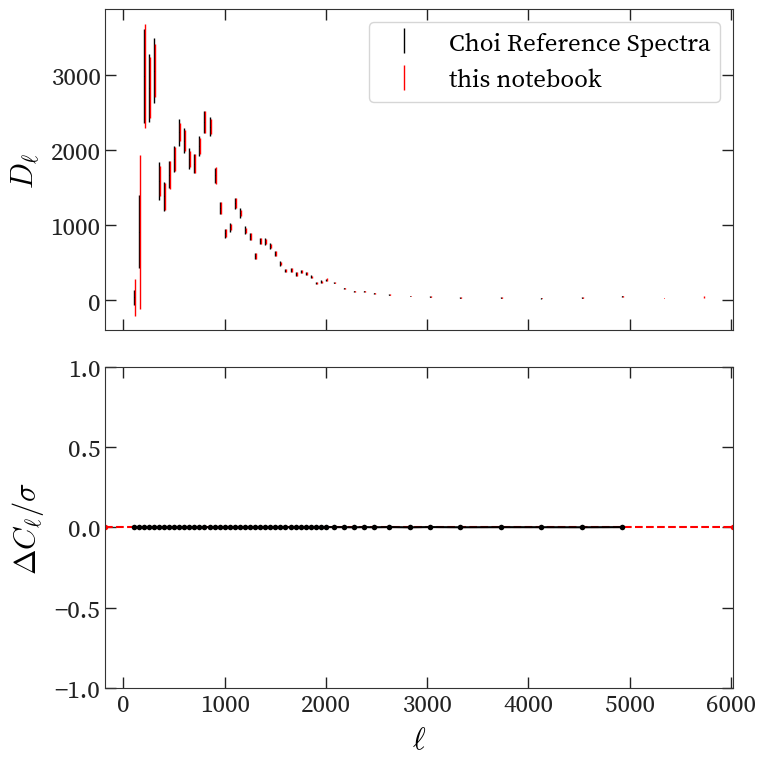

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Dltt[1:-3] 
axes[0].errorbar(lb + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lb + 1) + se_Dltt[1:-3]),
                 lw=1, ms=1, label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lb[:-2], (notebook_dl[:-2] - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylim(-1,1)
plt.tight_layout()

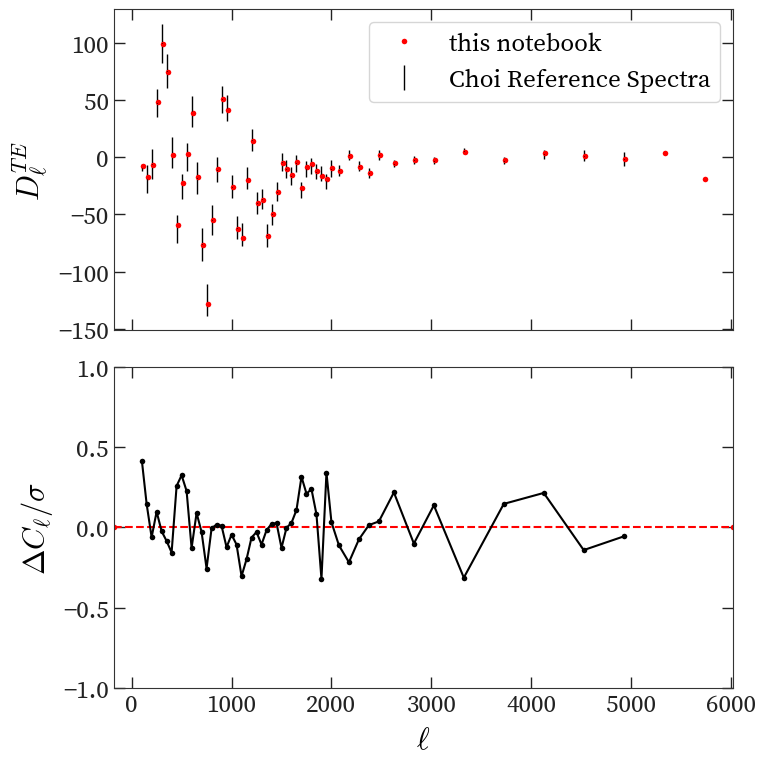

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TE_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Dlte[1:-3] 
axes[0].plot(lb + 10, notebook_dl, # we slightly offset to not overlap
             'r.', 
             label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}^{TE}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lb[:-2], (notebook_dl[:-2] - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylim(-1,1)
plt.tight_layout()

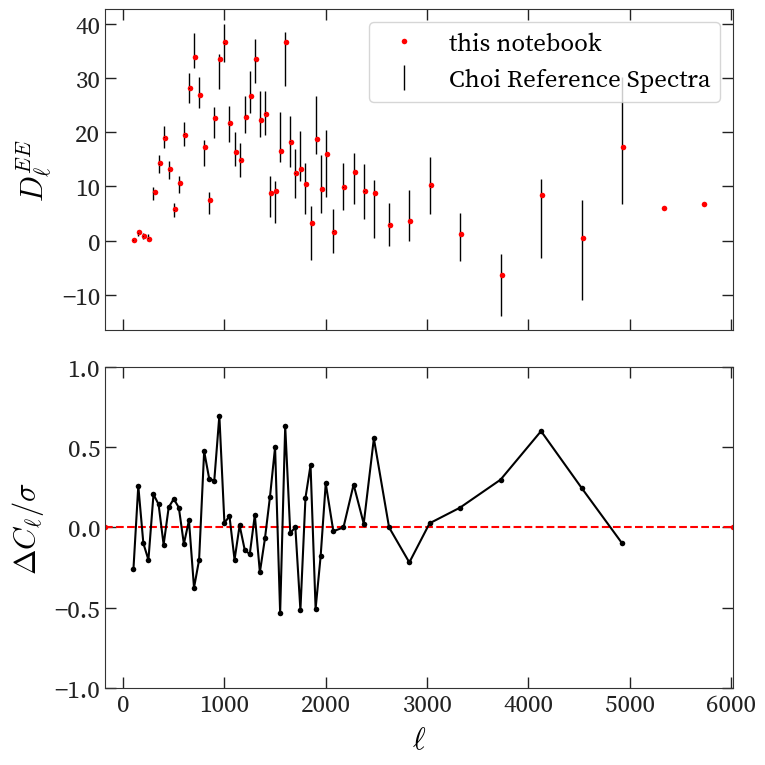

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_EE_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Dlee[1:-3] 
axes[0].plot(lb + 10, notebook_dl, # we slightly offset to not overlap
             'r.', 
             label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}^{EE}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lb[:-2], (notebook_dl[:-2] - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylim(-1,1)
plt.tight_layout()

## Analytic Covariance Matrices

Above, we estimated the covariance matrix from the standard error of the six split cross-spectra. We can instead estimate this analytically! We only have one mask in this example, which simplifies things a lot. If you assume each split has the same covariance matrix, then you only need to compute two covariances: the auto-spectrum and the cross-spectrum.

By default, nawrapper will estimate the noise power spectrum using step functions.

In [32]:
test = nw.nacov(namap_list[0], namap_list[1], mc, mc, mc)

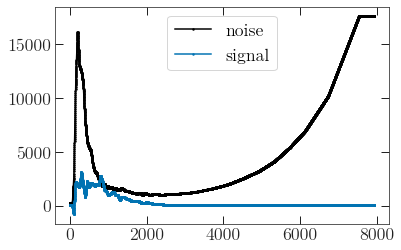

In [36]:
plt.plot(test.noise['T1T1'], label='noise')
plt.plot(test.signal['TT'], label='signal')
plt.legend()
# plt.yscale('log')
# plt.ylabel(r'power')

Essentially you need to know the noise and signal cross-spectra. Since covariance is a bilinear map, the mean of six cross-spectra follows the expressions below.

In [37]:
cross_cov = nw.compute_covmat(
    namap_list[0], namap_list[1], bins,
    mc_11=mc, mc_12=mc, mc_22=mc)

In [38]:
auto_cov = nw.compute_covmat(
    namap_list[0], namap_list[0], bins, 
    mc_11=mc, mc_12=mc, mc_22=mc)

These covariance results are just dictionaries containing keys to the covariance matrices, which you can access via something like `cross_cov['TTTT']`. We'll now combine them to calculate the mean covariance matrix.

In [39]:
from scipy.special import comb

# compute the number of cross-spectra from number of splits
n_spec = comb(nsplits, 2)

# weight covmats by autos and crosses to get mean covmat
cross_weight = n_spec**2 - n_spec
auto_weight = n_spec
combined_TT_cov = (
    cross_cov['TTTT'] * cross_weight / n_spec + 
    auto_cov['TTTT'] * auto_weight / n_spec
) / (n_spec**2)

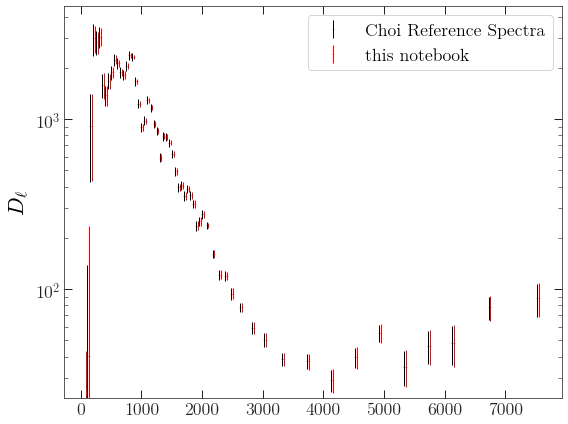

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:]
ax.errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=3, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb
ax.errorbar(lb + 30, mean_Dltt, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=np.sqrt(np.diag(combined_TT_cov)) / (lb * (lb+1) / 2 / np.pi),
                 lw=1, ms=3, label="this notebook")
ax.set_ylabel(r"$D_{\ell}$")
ax.legend(frameon=True)
plt.yscale('log')
plt.tight_layout()

# Bandpower Windows

In [11]:
bpw = mc.w00.get_bandpower_windows()

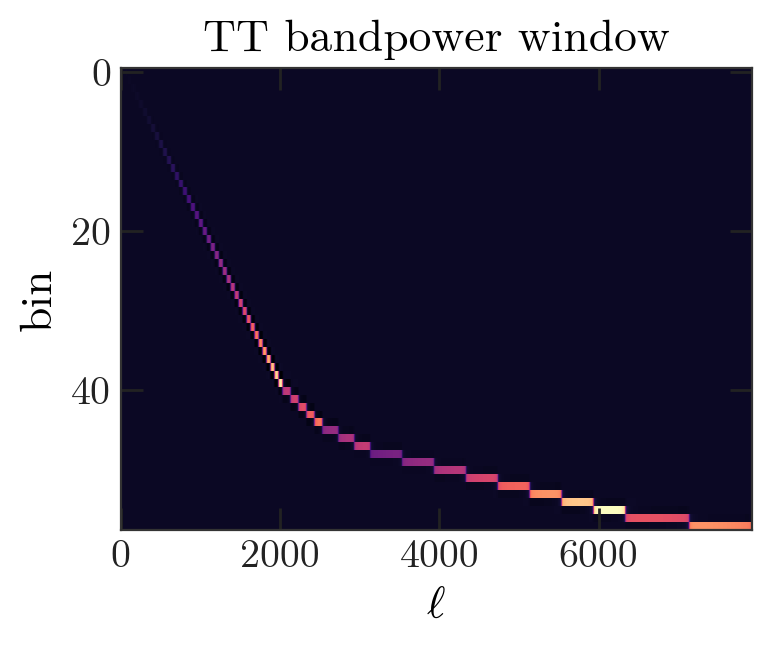

In [25]:
plt.imshow(bpw.reshape(58,7926), aspect=100)
plt.ylabel('bin')
plt.xlabel(r'$\ell$')
plt.title('TT bandpower window');